In [104]:
import zipfile
import os
from os import walk
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from bs4 import BeautifulSoup
%matplotlib inline

In [2]:
from google.colab import files
uploaded = files.upload()


Saving SpamData.zip to SpamData.zip


In [3]:
zip_file = 'SpamData.zip'
unzip_dir = '/content/DataExtracted'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)


In [ ]:
import os
current_directory = os.getcwd()
print("Current working directory:", current_directory)

**Constants**

In [4]:
EXAMPLE_FILE = 'DataExtracted/SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'DataExtracted/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'DataExtracted/SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'DataExtracted/SpamData/01_Processing/word-by-id.csv'


In [5]:
stream = open(EXAMPLE_FILE, encoding='utf-8')
message = stream.read()
stream.close()

print(message)

From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: from int-mx1.corp

In [6]:
stream = open(EXAMPLE_FILE, encoding='utf-8')
is_body = False
lines = []

for line in stream:
  if is_body:
    lines.append(line)
  elif line == '\n':
    is_body = True

stream.close()
email_body = '\n'.join(lines)

print(email_body)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

**Generator Functions**

In [7]:
def generate_squares(N):
  for my_number in range(N):
    yield my_number ** 2

In [8]:
for i in generate_squares(5):
  print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

**Email body extraction**

In [9]:
def email_body_generator(path):

  for root, dirnames, filenames in walk(path):
    for file_name in filenames:

      filepath = join(root, file_name)
      stream = open(filepath, encoding='latin-1')
      is_body = False
      lines = []

      for line in stream:
        if is_body:
          lines.append(line)
        elif line == '\n':
          is_body = True

      stream.close()
      email_body = '\n'.join(lines)

      yield file_name, email_body

In [10]:
def df_from_directory(path,classification):
  rows = []
  row_names = []

  for file_name, email_body in email_body_generator(path):
    rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
    row_names.append(file_name)


  return pd.DataFrame(rows, index=row_names)

In [11]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = pd.concat([spam_emails, df_from_directory(SPAM_2_PATH, 1)])
spam_emails.head()

,MESSAGE,CATEGORY
00416.bff1badad869f205fdb54f311f060734,\n\n<html>\n\n<head>\n\n\n\n</head>\n\n<body b...,1
00023.b6d27c684f5fc803cfa1060adb2d0805,------=_NextPart_000_00B2_83B03D1E.C6530E24\n\...,1
00038.8d93819b95ff90bf2e2b141c2909bfc9,--TEP-2108411027.1463792894.1027038601\n\nCont...,1
00331.a61788d316e7393c8bbf8ee19b24c713,<HTML><HEAD><TITLE></TITLE><META http-equiv=3D...,1
00226.e0e2704cde3bbd561a98042f4a3baf5f,"Dear Sir or Madam,\n\n\n\nMy name is Petr Stan...",1


In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, 0)
ham_emails = pd.concat([ham_emails, df_from_directory(EASY_NONSPAM_2_PATH, 0)])
ham_emails.shape

(3901, 2)

In [13]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire DataFrame is:', data.shape)
data.head()

Shape of entire DataFrame is: (5799, 2)


,MESSAGE,CATEGORY
00416.bff1badad869f205fdb54f311f060734,\n\n<html>\n\n<head>\n\n\n\n</head>\n\n<body b...,1
00023.b6d27c684f5fc803cfa1060adb2d0805,------=_NextPart_000_00B2_83B03D1E.C6530E24\n\...,1
00038.8d93819b95ff90bf2e2b141c2909bfc9,--TEP-2108411027.1463792894.1027038601\n\nCont...,1
00331.a61788d316e7393c8bbf8ee19b24c713,<HTML><HEAD><TITLE></TITLE><META http-equiv=3D...,1
00226.e0e2704cde3bbd561a98042f4a3baf5f,"Dear Sir or Madam,\n\n\n\nMy name is Petr Stan...",1


In [ ]:
data.tail()

,MESSAGE,CATEGORY
00911.91dd363a1ba091de446dd40a24816ab3,"On Fri, 26 Jul 2002, Ian Andrew Bell wrote:\n\...",0
01090.9c92673e26cabc5a37ac3e2b1b2bf8df,\n\n\n\nJohn Hall\n\n13464 95th Ave NE\n\nKirk...,0
00664.28f4cb9fad800d0c7175d3a67e6c6458,"Key concepts: Tokyo, urban overheating,\n\ncl...",0
00715.c11e77af45a2debe41aed46b2be09d59,\n\nMusic school jokes --\n\n\n\nAmerican cond...,0
00492.bc9e8dcbe986afe7ed1f38e988f43c8b,"As list administrator, your authorization is r...",0


**Data Cleaning: Checking for missing values**

In [ ]:
#Check if any message bodies are null
#data.MESSAGE
#second option
data['MESSAGE'].isnull().values.any()


False

In [14]:
#check if there are empty emails(string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [15]:
(data.MESSAGE.str.len() == 0).sum()

3

In [16]:
data.MESSAGE.isnull().sum()

0

**Locate empty emails**

In [17]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [18]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [19]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

**Remove System File Entries from Dataframe**

In [20]:
data.drop(['cmds'], inplace=True)


In [21]:
data.shape

(5796, 2)

**Add Document Ids to track emails in dataset**

In [22]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids


In [23]:
data.DOC_ID

,DOC_ID
00416.bff1badad869f205fdb54f311f060734,0
00023.b6d27c684f5fc803cfa1060adb2d0805,1
00038.8d93819b95ff90bf2e2b141c2909bfc9,2
00331.a61788d316e7393c8bbf8ee19b24c713,3
00226.e0e2704cde3bbd561a98042f4a3baf5f,4
...,...
00855.25cdd1d4b3805757439866eb261643f6,5791
01394.b4dd1cece01b908f040e33493643c4a4,5792
01234.538d99529a2f797af84e2aadebce58b7,5793
00816.953e88a20d4acc17467a8ee832481093,5794


In [24]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,\n\n<html>\n\n<head>\n\n\n\n</head>\n\n<body b...,1,00416.bff1badad869f205fdb54f311f060734
1,------=_NextPart_000_00B2_83B03D1E.C6530E24\n\...,1,00023.b6d27c684f5fc803cfa1060adb2d0805
2,--TEP-2108411027.1463792894.1027038601\n\nCont...,1,00038.8d93819b95ff90bf2e2b141c2909bfc9
3,<HTML><HEAD><TITLE></TITLE><META http-equiv=3D...,1,00331.a61788d316e7393c8bbf8ee19b24c713
4,"Dear Sir or Madam,\n\n\n\nMy name is Petr Stan...",1,00226.e0e2704cde3bbd561a98042f4a3baf5f


In [25]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,email. I could see certain friends of mine g...,0,00855.25cdd1d4b3805757439866eb261643f6
5792,\n\n\n\n\n\nhttp://news.bbc.co.uk/1/hi/scotlan...,0,01394.b4dd1cece01b908f040e33493643c4a4
5793,"On Wed, Aug 14, 2002 at 10:59:22AM -0400, Thom...",0,01234.538d99529a2f797af84e2aadebce58b7
5794,">>>>> ""O"" == Owen Byrne <owen@permafrost.net> ...",0,00816.953e88a20d4acc17467a8ee832481093
5795,"On 9 Aug 2002, Gary Lawrence Murphy wrote:\n\n...",0,00993.cff996c201ffd0122c92ff6b670afc96


**Save to file using Pandas**

In [26]:
data.to_json(DATA_JSON_FILE)

**Number of spam messages visualised**

In [27]:
data.CATEGORY.value_counts()

,count
CATEGORY,
0,3900
1,1896


In [28]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]
print('Amount of spam messages:', amount_of_spam)
print('Amount of ham messages:', amount_of_ham)

Amount of spam messages: 1896
Amount of ham messages: 3900


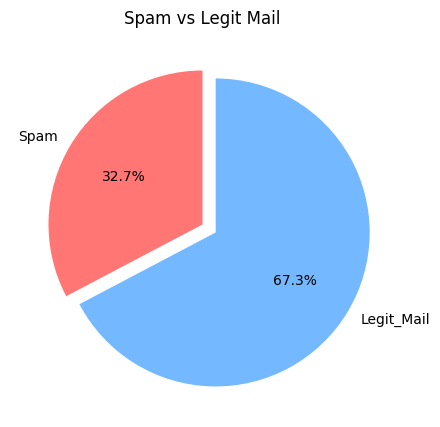

In [29]:
category_names = ['Spam', 'Legit_Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675','#74b9ff']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, explode=[0, 0.1])
plt.title('Spam vs Legit Mail')
plt.show()

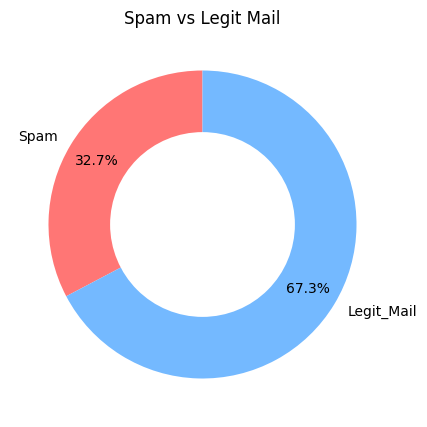

In [30]:
category_names = ['Spam', 'Legit_Mail']
sizes = [amount_of_spam, amount_of_ham]

custom_colors = ['#ff7675','#74b9ff']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, pctdistance=0.8)

#draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Spam vs Legit Mail')
plt.show()

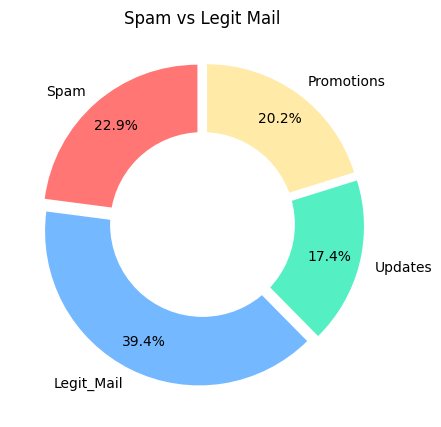

In [31]:
category_names = ['Spam', 'Legit_Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
offset = [0.05, 0.05, 0.05, 0.05]

custom_colors = ['#ff7675','#74b9ff', '#55efc4', '#ffeaa7']
plt.figure(figsize=(5, 5), dpi=100)
plt.pie(sizes, labels=category_names, textprops={'fontsize':10},
        startangle=90, autopct='%1.1f%%', colors = custom_colors, pctdistance=0.8, explode=offset)

#draw circle
centre_circle = plt.Circle((0,0), radius=0.6, fc='white')

fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Spam vs Legit Mail')
plt.show()

# **Natural Language Processing**
**Text Pre-Processing**

In [32]:
msg = 'All work and no play makes Jack a dull boy'
msg.lower()

'all work and no play makes jack a dull boy'

**Download the NLTK Resources(Tokenizer & Stopwords)**

In [35]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**Tokenising**

In [38]:
msg = 'All work and no play makes Jack a dull boy'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy']

**Removing stop words**

In [39]:
stop_words = set(stopwords.words('english'))

In [40]:
if 'this' in stop_words:
  print('True')
else:
  print('Nope.Not in here')

True


In [41]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
  if word not in stop_words:
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy.to', 'question', '.']


**Word Stems and Stemming**

In [42]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question. \
Nobody expects Spanish Inquisition'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []

for word in words:
  if word not in stop_words:
    stemmed_word = stemmer.stem(word)
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'boy.to', 'question', '.', 'nobody', 'expects', 'spanish', 'inquisition']


In [43]:
msg = 'All work and no play makes Jack a dull boy.To be or not to be that is the question.??? \
Nobody expects Spanish Inquisition'
words = word_tokenize(msg.lower())

#stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')
filtered_words = []

for word in words:
  if word not in stop_words and word.isalpha():
    stemmed_word = stemmer.stem(word)
    filtered_words.append(word)

print(filtered_words)


['work', 'play', 'makes', 'jack', 'dull', 'nobody', 'expects', 'spanish', 'inquisition']


**Removing HTML tags from emails**

In [44]:
soup = BeautifulSoup(data.at[2, 'MESSAGE'], 'html.parser')
print(soup.prettify())

--TEP-2108411027.1463792894.1027038601

Content-Type: text/plain



Dear STUART,



Are you tired of searching for love in all the wrong places?





Find LOVE NOW at Date.com!

http://click.emailrewardz.email-publisher.com/maaaqZGaaSKm2aa6syje/





Browse through thousands of personals in your area.





JOIN FOR FREE!

http://click.emailrewardz.email-publisher.com/maaaqZGaaSKm2aa6syje/





- Search, E-mail &amp; Chat

- Use Date.com to meet cool guys and hot girls.

- Go 1 on 1 or use our private chat rooms.





Click on the link to get started!

http://click.emailrewardz.email-publisher.com/maaaqZGaaSKm2aa6syje/



Find LOVE NOW!

----------------------------------



You have received this email because you have registerd with EmailRewardz or subscribed through one of our marketing partners. If you have received this message in error, or wish to stop receiving these great offers please click the remove link above. 



To unsubscribe from these mailings, please click here:

http:

In [45]:
soup.get_text()

'--TEP-2108411027.1463792894.1027038601\n\nContent-Type: text/plain\n\n\n\nDear STUART,\n\n\n\nAre you tired of searching for love in all the wrong places?\n\n\n\n\n\nFind LOVE NOW at Date.com!\n\nhttp://click.emailrewardz.email-publisher.com/maaaqZGaaSKm2aa6syje/\n\n\n\n\n\nBrowse through thousands of personals in your area.\n\n\n\n\n\nJOIN FOR FREE!\n\nhttp://click.emailrewardz.email-publisher.com/maaaqZGaaSKm2aa6syje/\n\n\n\n\n\n- Search, E-mail & Chat\n\n- Use Date.com to meet cool guys and hot girls.\n\n- Go 1 on 1 or use our private chat rooms.\n\n\n\n\n\nClick on the link to get started!\n\nhttp://click.emailrewardz.email-publisher.com/maaaqZGaaSKm2aa6syje/\n\n\n\nFind LOVE NOW!\n\n----------------------------------\n\n\n\nYou have received this email because you have registerd with EmailRewardz or subscribed through one of our marketing partners. If you have received this message in error, or wish to stop receiving these great offers please click the remove link above. \n\n\n\n

**Fuctions for email processing**

In [46]:
def clean_message(message, stemmer=PorterStemmer(),
                  stop_words = set(stopwords.words('english'))):

   words = word_tokenize(message.lower())
   filtered_words = []

   for word in words:
    if word not in stop_words and word.isalpha():
      stemmed_word = stemmer.stem(word)
      filtered_words.append(stemmer.stem(word))


   return filtered_words


In [47]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [56]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [61]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index
doc_ids_ham


Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       ...
       5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
      dtype='int64', name='DOC_ID', length=3900)

***Subsetting a Series with Index***

In [62]:
type(doc_ids_ham)

pandas.core.indexes.base.Index

In [ ]:
#type(nested_list)

In [63]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_ham.shape

(3900,)

In [59]:
nested_list_ham.tail()

,MESSAGE
DOC_ID,
5791,"[email, could, see, certain, friend, mine, get..."
5792,"[http, yahoo, group, sponsor, dvd, free, p, jo..."
5793,"[wed, aug, thoma, baker, wrote, anyon, luck, g..."
5794,"[owen, byrn, write, well, imnho, compani, rewa..."
5795,"[aug, gari, lawrenc, murphi, wrote, restat, as..."


In [64]:
nested_list_spam = nested_list.loc[doc_ids_spam]

In [65]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
normal_words.shape[0]  #total number an unique words in a non-spam messages

20815

In [66]:
normal_words[:10]

,count
http,7563
use,3633
list,2880
one,2373
get,2286
mail,2255
would,2003
like,1931
messag,1849
work,1800


In [67]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spammy_words = pd.Series(flat_list_spam).value_counts()
spammy_words.shape[0]  #total number an unique words in spam messages

13242

In [68]:
spammy_words[:10]

,count
http,3097
email,3090
free,2585
click,2058
receiv,1989
list,1971
get,1914
pleas,1852
busi,1792
order,1746


**Generate Vocabulary and Dictionary**

In [69]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]


<ipython-input-48-8c79fd6a633b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
<ipython-input-48-8c79fd6a633b>:4: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [70]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words',unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


,count
http,10660
use,5019
list,4851
email,4367
get,4200


In [74]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Nr of frequent words \n', frequent_words[:10])


Nr of frequent words 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
Name: count, dtype: int64


**Create Vocabulary DataFrame with a WORD_ID**

In [75]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
VOCAB_SIZE = len(vocab)
vocab.index.name = 'WORD_ID'
vocab.head()


,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


**Save the vocabulary as a csv file**

In [ ]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name )

**Checking if a word is part of the vocabulary**

In [77]:
any(vocab.VOCAB_WORD == 'machine')

True

In [82]:
'app' in set(vocab.VOCAB_WORD)

False

**Find the email with the most number of  words**

In [83]:
clean_email_lengths = []
for sublist in stemmed_nested_list:
  clean_email_lengths.append(len(sublist))

In [85]:
clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [89]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe) 4843


In [90]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [94]:
word_columns_df = data.at[np.argmax(clean_email_lengths), 'MESSAGE']


**Generate Features & Sparse Matrix**

**Creating a Dataframe with one Word per Column **

In [96]:
type(stemmed_nested_list[2])

list

In [102]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,best,mortag,rate,simpl,easi,free,hundr,lender,compet,loan,...,None,None,None,None,None,None,None,None,None,None
1,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,dear,stuart,tire,search,love,wrong,place,find,love,http,...,None,None,None,None,None,None,None,None,None,None
3,newslett,discov,tomorrow,winner,immedi,releas,stock,symbol,cbyi,watch,...,None,None,None,None,None,None,None,None,None,None
4,dear,sir,madam,name,petr,stanek,manag,free,trial,subscript,...,None,None,None,None,None,None,None,None,None,None


In [103]:
word_columns_df.shape

(5796, 7671)

**Splitting the Data into a Traininhg and Testing Dataset**

In [105]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [106]:
print('Nr of training samples', X_train.shape[0])
print('Nr of testing samples', X_test.shape[0]/ word_columns_df.shape[0])

Nr of training samples 4057
Nr of testing samples 0.3000345065562457


In [113]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,pleas,see,http,snipet,extract,esp,packag,archiv,tar,xvf,...,None,None,None,None,None,None,None,None,None,None
4727,gari,lawrenc,murphi,whitelist,fan,someon,pleas,tell,us,follow,...,None,None,None,None,None,None,None,None,None,None
5022,pgp,sign,messag,secur,advisori,freebsd,project,topic,bug,nf,...,None,None,None,None,None,None,None,None,None,None
3504,url,http,date,suppli,img,http,wonder,galleri,histor,advertis,...,None,None,None,None,None,None,None,None,None,None
3921,yannick,gingra,wrote,wonder,techniqu,make,like,unbreak,either,give,...,None,None,None,None,None,None,None,None,None,None


In [110]:
y_train.head()

,CATEGORY
DOC_ID,
4844,0
4727,0
5022,0
3504,0
3921,0


**Create a Sparse Matrix for the Training Data**

In [111]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [137]:
def make_sparse_matrix(df, indexed_words, labels):
   """
   Returns sparse matrix as dataframe.

   df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
   indexed_words: index of words ordered by word id
   labels: category as a seeries (y_train or y_test)

   """
   nr_rows = df.shape[0]
   nr_cols = df.shape[1]
   word_set = set(indexed_words)
   dict_list = []

   for i in range(nr_rows):
    doc_id = df.index[i]
    for j in range(nr_cols):
      word = df.iat[i, j]
      if word in word_set:

        word_id = indexed_words.get_loc(word)
        category = labels.iloc[i]

        item = {'LABEL': category,'DOC_ID': doc_id,
               'OCCURENCE': 1,'WORD_ID': word_id}
        dict_list.append(item)
   return pd.DataFrame(dict_list)


In [129]:
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

**Combine Occurences with the Pandas gtoupby() Method**

In [123]:
vocab.at[0, 'VOCAB_WORD']

'machine'

In [124]:
data.MESSAGE[0]

'\n\n<html>\n\n<head>\n\n\n\n</head>\n\n<body bgcolor=#FFFFFF text=#000000 >\n\n<table width=100% height=100% border=0 cellspacing=0 cellpadding=0 >\n\n  <tr>\n\n    <td valign=middle > \n\n      <div align=center> \n\n        <table width=550 border=0 cellspacing=0 cellpadding=0>\n\n          <tr> \n\n            <td width=22 height=50 bgcolor=D5D5D5>&nbsp;</td>\n\n            <td width=213 height=50 bgcolor=D5D5D5>&nbsp;<font size="2" face="Verdana, Arial, Helvetica, sans-serif"><strong>&nbsp;&nbsp;The \n\n              Best Mortage Rates</strong></font></td>\n\n            <td colspan=2 height=50 bgcolor=979797>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<font face=Verdana, Arial, Helvetica, sans-serif color=#FFFFFF><b>Simple, \n\n              Easy and FREE</b></font></td>\n\n            <td width=22 height=50 bgcolor=D5D5D5>&nbsp; </td>\n\n          </tr>\n\n          <tr> \n\n            <td width=22 height=25 bgcolor=D5D5D5>&nbsp;</td>\n\n            <td width=213 height=25 bgcolor=979797>&nb